In [13]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.linalg import hankel
from utils import params
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

In [14]:
def MAPE(y_true, y_pred):
    mask = y_true != 0
    y_true, y_pred = np.array(y_true)[mask], np.array(y_pred)[mask]
    if len(y_true) == 0:
        return np.nan
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
with open('Results/final_output.pkl', 'rb') as f:
    results = pickle.load(f)
X_ori = results['x'].cpu().detach().numpy()
dx_ori = results['dx'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

measured_index = [i*params['embedding_dimension'] for i in range(params['partial_measurement'])]
X_ori = X_ori[:, measured_index]
dx_ori = dx_ori[:, measured_index]

In [16]:
train_loss = np.load("Results/train_loss.npy")
val_loss = np.load("Results/val_loss.npy")

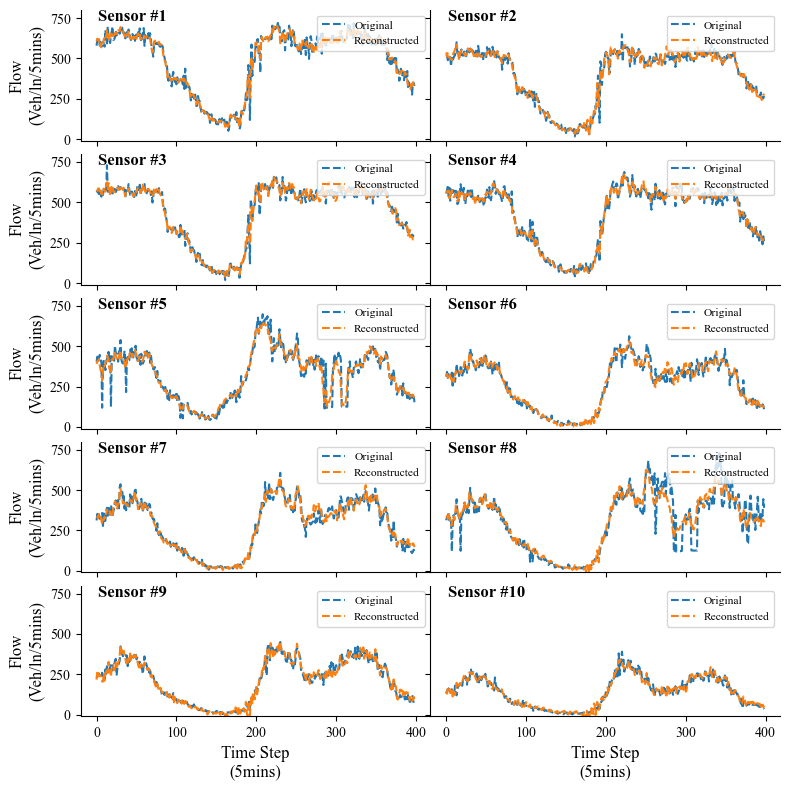

In [17]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8, 8), sharex=True, sharey=True)

# Plot each column in a separate subplot
for row in range(5):
    for col in range(2):
        axs[row, col].plot(100*X_ori[:, row*2 + col], "--", label = 'Original')
        axs[row, col].plot(100*z[:, row*2 + col], "--", label = 'Reconstructed')
        axs[row, col].set_ylim([-10, 800])
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].text(0.05, 1.00, f'Sensor #{(row*2 + col)+1}', transform=axs[row, col].transAxes, va='top', ha='left', fontsize = 12, weight='bold')
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)

for col in range(2):
    axs[4,col].set_xlabel('Time Step\n(5mins)', fontsize = 12)

for row in range(5):
    axs[row,0].set_ylabel('Flow\n(Veh/ln/5mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/Ori_Recon_Plot.png",dpi=300)

In [18]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*X_ori[:, i], 100*z[:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [19]:
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/recon_accuracy.csv")
accuracy

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,24.84,26.93,22.24,22.629999,39.32,27.370001,26.940001,64.629997,21.940001,19.4


In [20]:
accuracy.mean(axis=1)

1    29.623999
dtype: float32

In [22]:
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100*X_ori[:, i], 100*z[:,i])
    mape_i[f'Station #{i+1}'] =mape_curr

accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/recon_accuracy_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,4.91,7.26,5.04,5.28,10.92,11.67,11.25,21.09,15.8,24.4


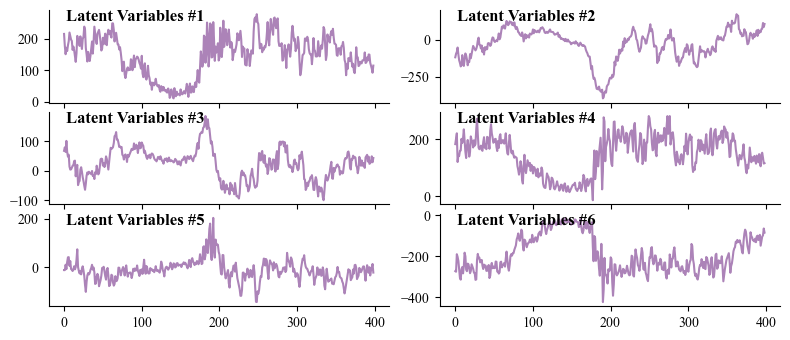

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 3.5), sharex=True)

# Plot each column in a separate subplot
for row in range(3):
    for col in range(2):
        #axs[row, col].plot(100*X_ori[:, -(row*2 + col)], "--", label = 'Original')
        axs[row, col].plot(100*z[:, -(row*2 + col + 1)], color = "#ac83b8", label = 'Reconstructed')
        #axs[row, col].set_title(f'Latent Variables #{(row*2 + col)+1}')
        axs[row, col].text(0.05, 1.00, f'Latent Variables #{(row*2 + col)+1}', transform=axs[row, col].transAxes, va='top', ha='left', fontsize = 12, weight='bold')
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)

for col in range(2):
    axs[1, col].set_xlabel('Time Step (5mins)', fontsize = 12)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.15)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/Latent_Plot.png",dpi=300)

In [24]:
dz_predict = results['dz_predict'].cpu().detach().numpy()
dz = results['dz'].cpu().detach().numpy()

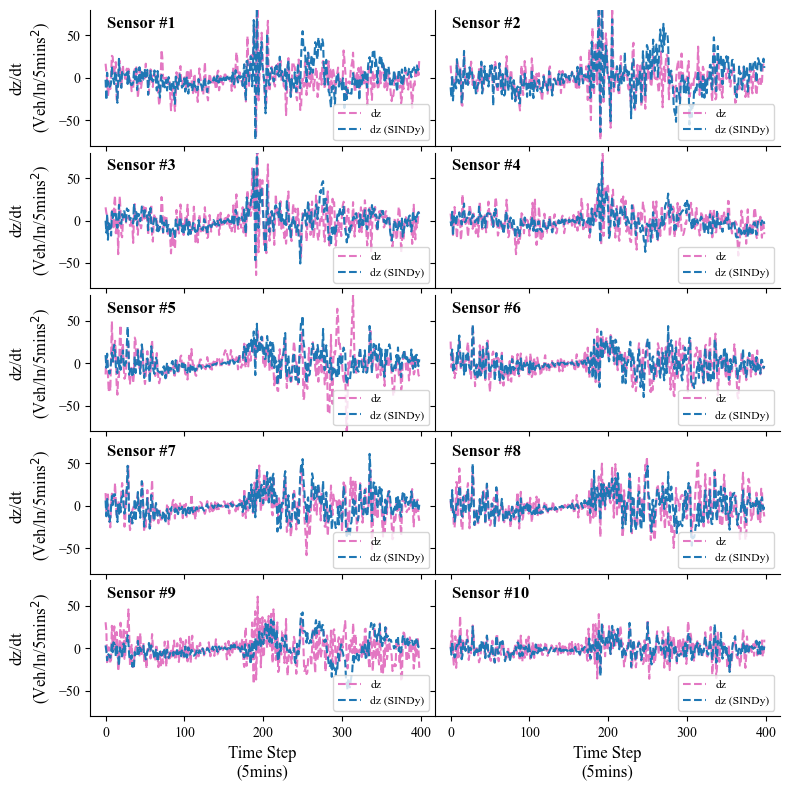

In [25]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8, 8), sharex=True, sharey=True)

# Plot each column in a separate subplot
for row in range(5):
    for col in range(2):
        #axs[row, col].plot(dx_ori[:, row*2 + col], label = 'dx')
        axs[row, col].plot(100*dz[:, row*2 + col], "--", color = '#e377c2', label = 'dz')
        axs[row, col].plot(100*dz_predict[:, row*2 + col], "--", color = '#1f77b4' ,label = 'dz (SINDy)')
        #axs[row, col].set_title(f'Sensor #{(row*2 + col)+1}')
        #axs[row, col].set_xlabel('Time Step (5mins)', fontsize = 12)
        #axs[row, col].set_ylabel('dz/dt', fontsize = 12)
        axs[row, col].set_ylim([-80, 80])
        axs[row, col].legend(loc='lower right', fontsize='small')
        axs[row, col].text(0.05, 0.95, f'Sensor #{(row*2 + col)+1}', transform=axs[row, col].transAxes, va='top', ha='left', fontsize = 12, weight='bold')
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)

for col in range(2):
    axs[4,col].set_xlabel('Time Step\n(5mins)', fontsize = 12)

for row in range(5):
    axs[row,0].set_ylabel('dz/dt\n(Veh/ln/5mins$^2$)', fontsize = 12)

# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig("Figures/dz_dzSINDy_Plot.png", dpi=300)

In [26]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*dz[:, i], 100*dz_predict[:, i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [27]:
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/Time_Derivative.csv")
accuracy

1    14.851
dtype: float32

In [28]:
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100*dz[:, i], 100*dz_predict[:, i])
    mape_i[f'Station #{i+1}'] =mape_curr

accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/Time_Derivative_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,20610.04,679.78,1254.46,242.31,238.0,2097.5,288.34,282.68,396.39,205.8


# 5mins prediction

In [29]:
from sindy_utils import sindy_library
sim_result_1 = np.zeros(z.shape)
sim_result_2 = np.zeros(z.shape)
sim_result_3 = np.zeros(z.shape)

In [30]:
for t in range(z.shape[0]):
    z_current = z[t,:].reshape(1,-1)
    Theta_curr = sindy_library(z_current,2,False)
    dz_curr = np.matmul(Theta_curr, sindy_coeff)
    z_next = z_current + dz_curr
    sim_result_1[t,:] = z_next

In [31]:
np.save("Pred_Results/one_step_pred_proposed.npy", sim_result_1)
np.save("Pred_Results/z.npy", z)

In [32]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_1[:-1, i], 100*z[1:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [33]:
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindyAE.csv")
accuracy.mean(axis=1)

1    19.904
dtype: float64

In [34]:
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100*z[1:,i], 100*sim_result_1[:-1, i])
    mape_i[f'Station #{i+1}'] =mape_curr

accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/sindyAE_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,3.69,5.21,4.69,4.49,5.4,10.53,13.16,12.16,37.94,50.39


In [35]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_1[:-1, i], 100*X_ori[1:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [36]:
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindyAE_compared_with_ori.csv")
accuracy.mean(axis=1)

1    31.673
dtype: float64

In [37]:
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100*X_ori[1:,i], 100*sim_result_1[:-1, i])
    mape_i[f'Station #{i+1}'] =mape_curr

accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/sindyAE_compared_with_ori_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,5.9,5.7,7.04,6.69,10.68,12.13,12.77,18.28,19.89,24.54


# 10mins predictions

In [38]:
for t in range(sim_result_1.shape[0]):
    z_current = sim_result_1[t,:].reshape(1,-1)
    Theta_curr = sindy_library(z_current,2,False)
    dz_curr = np.matmul(Theta_curr, sindy_coeff)
    z_next = z_current + dz_curr
    sim_result_2[t,:] = z_next

In [39]:
np.save("Pred_Results/two_step_pred_proposed.npy", sim_result_2)

In [40]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_2[:-2, i], 100*z[2:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [41]:
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindyAE_10mins.csv")
accuracy.mean(axis=1)

1    28.577
dtype: float64

In [42]:
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100*z[2:,i], 100*sim_result_2[:-2, i])
    mape_i[f'Station #{i+1}'] =mape_curr

accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/sindyAE_10mins_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,5.3,8.79,5.76,5.85,8.15,16.92,16.59,17.85,75.44,68.98


In [43]:
rmse_i = {}
for i in range(params['partial_measurement']):
    rmse_curr = np.sqrt(mse(100*sim_result_2[:-2, i], 100*X_ori[2:,i]))
    rmse_i[f'Station #{i+1}'] = rmse_curr

In [44]:
accuracy = pd.DataFrame(rmse_i, index=[1]).round(2)
accuracy.to_csv("Accuracy_Metric/sindyAE_10mins_compared_with_ori.csv")
accuracy.mean(axis=1)

1    34.815
dtype: float64

In [46]:
mape_i = {}
for i in range(params['partial_measurement']):
    mape_curr = MAPE(100*X_ori[2:,i], 100*sim_result_2[:-2, i])
    mape_i[f'Station #{i+1}'] =mape_curr

accuracy_mape = pd.DataFrame(mape_i, index=[1]).round(2)
accuracy_mape.to_csv("Accuracy_Metric/sindyAE_10mins_compared_with_ori_MAPE.csv")
accuracy_mape

,Station #1,Station #2,Station #3,Station #4,Station #5,Station #6,Station #7,Station #8,Station #9,Station #10
1,6.55,8.16,7.31,6.4,11.6,14.2,12.92,19.62,20.31,24.09


# Phases

In [55]:
import random
indices = [x for x in range(params['partial_measurement']) if x != 7]
index_pair = []
for i in range(params['partial_measurement']-1):
    for j in range(i+1, params['partial_measurement']-1):
        index_pair.append((indices[i], indices[j]))

random.seed(8)
index_pair = random.sample(index_pair, 3)

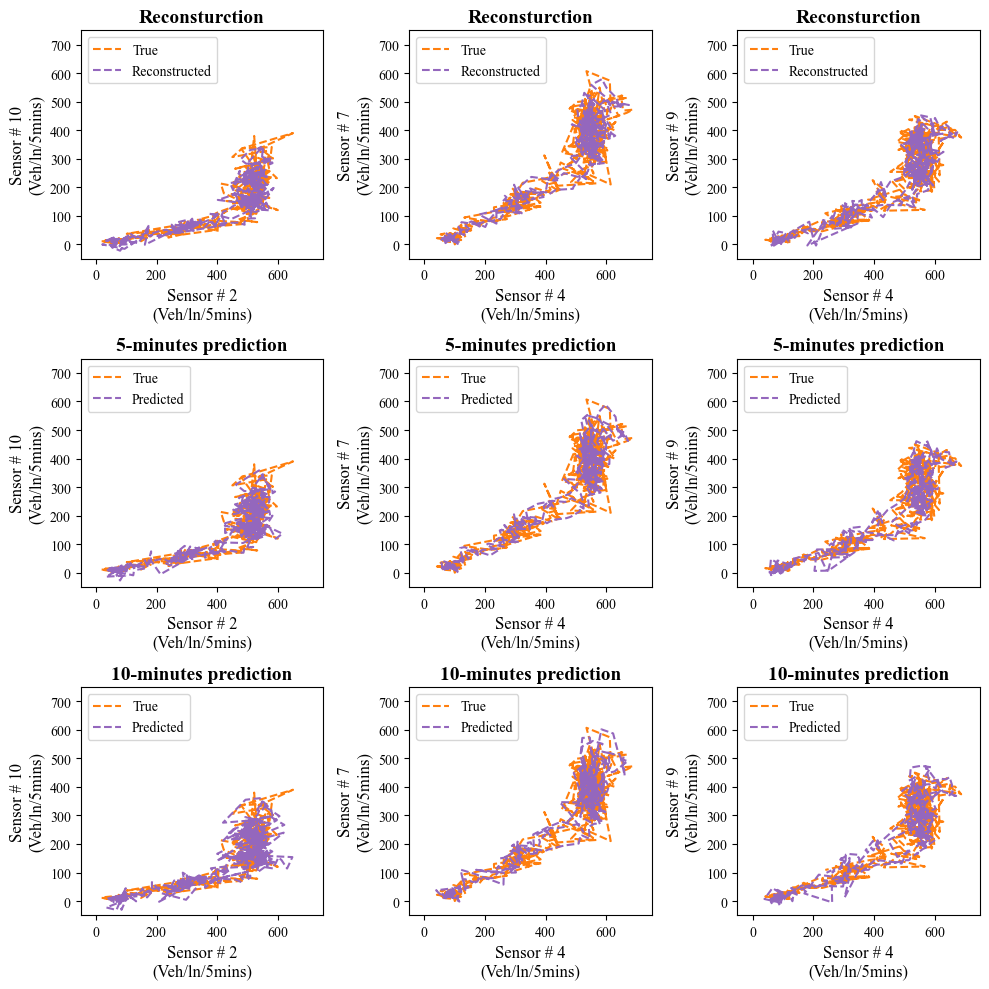

In [57]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))


for col in range(3):
    index1 = index_pair[col][0]
    index2 = index_pair[col][1]
    axs[0, col].plot(100 * X_ori[:,index1], 100 * X_ori[:,index2], "--", color = '#ff7f0e', label = 'True')
    axs[0, col].plot(100 * z[:,index1], 100 * z[:,index2], "--", color = '#9467bd', label = 'Reconstructed')
    #axs[0, col].plot(100 * sim_result_1[1:,index1], 100 * sim_result_1[1:,index2], "--", color = '#9467bd', label = 'Predicted')
    axs[0, col].legend(loc='upper left', fontsize='medium')
    axs[0, col].set_xlabel(f'Sensor # {index1 + 1}\n(Veh/ln/5mins)', fontsize = 12)
    axs[0, col].set_ylabel(f'Sensor # {index2 + 1}\n(Veh/ln/5mins)', fontsize = 12)
    axs[0, col].set_ylim([-50, 750])
    axs[0, col].set_xlim([-50, 750])
    axs[0, col].set_title("Reconsturction", fontsize = 14, weight='bold')
    #axs[0, col].text(0.05, 0.95, '5-minutes prediction', transform=axs[0, col].transAxes, va='top', ha='left', fontsize = 12, weight='bold')

for col in range(3):
    index1 = index_pair[col][0]
    index2 = index_pair[col][1]
    axs[1, col].plot(100 * X_ori[:-1,index1], 100 * X_ori[:-1,index2], "--", color = '#ff7f0e', label = 'True')
    # axs[1, col].plot(100 * z[:-1,index1], 100 * z[:-1,index2], "--", color = '#ff7f0e', label = 'Reconstructed')
    axs[1, col].plot(100 * sim_result_1[1:,index1], 100 * sim_result_1[1:,index2], "--", color = '#9467bd', label = 'Predicted')
    axs[1, col].legend(loc='upper left', fontsize='medium')
    axs[1, col].set_xlabel(f'Sensor # {index1 + 1}\n(Veh/ln/5mins)', fontsize = 12)
    axs[1, col].set_ylabel(f'Sensor # {index2 + 1}\n(Veh/ln/5mins)', fontsize = 12)
    axs[1, col].set_ylim([-50, 750])
    axs[1, col].set_xlim([-50, 750])
    axs[1, col].set_title("5-minutes prediction", fontsize = 14, weight='bold')
    #axs[0, col].text(0.05, 0.95, '5-minutes prediction', transform=axs[0, col].transAxes, va='top', ha='left', fontsize = 12, weight='bold')


for col in range(3):
    index1 = index_pair[col][0]
    index2 = index_pair[col][1]
    axs[2, col].plot(100 * X_ori[:-2,index1], 100 * X_ori[:-2,index2], "--", color = '#ff7f0e', label = 'True')
    # axs[2, col].plot(100 * z[:-2,index1], 100 * z[:-2,index2], "--", color = '#ff7f0e', label = 'Reconstructed')
    axs[2, col].plot(100 * sim_result_2[2:,index1], 100 * sim_result_2[2:,index2], "--", color = '#9467bd', label = 'Predicted')
    axs[2, col].legend(loc='upper left', fontsize='medium')
    axs[2, col].set_xlabel(f'Sensor # {index1 + 1}\n(Veh/ln/5mins)', fontsize = 12)
    axs[2, col].set_ylabel(f'Sensor # {index2 + 1}\n(Veh/ln/5mins)', fontsize = 12)
    axs[2, col].set_ylim([-50, 750])
    axs[2, col].set_xlim([-50, 750])
    axs[2, col].set_title("10-minutes prediction", fontsize = 14, weight='bold')
    # axs[1, col].text(0.05, 0.95, '10-minutes prediction', transform=axs[1, col].transAxes, va='top', ha='left', fontsize = 12, weight='bold')

plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig("Figures/predicted_and_z_phase.png", dpi = 300)

In [31]:
coeff = pd.DataFrame(sindy_coeff.T)
coeff.to_csv("Tables/sindy_coeff.csv")